In [1]:
!pip install rasterio pillow

In [2]:
import numpy as np
from PIL import Image

# === Paths ===
img_file = "/content/drive/MyDrive/Moon Datasets IMG/ch2_ohr_ncp_20230227T0133276778_d_img_n18.img"
tiff_output = "/content/drive/MyDrive/Moon Datasets IMG/output_full.tif"
preview_output = "/content/drive/MyDrive/Moon Datasets IMG/output_preview.jpg"

# Dimensions from CSV
width = 12000
height = 101074

# Step 1: Read as 8-bit
data = np.fromfile(img_file, dtype=np.uint8)
image = data.reshape((height, width))

# Step 2: Save full resolution as TIFF (cloud storage, big file)
full_img = Image.fromarray(image)
full_img.save(tiff_output, "TIFF")
print(f"✅ Full-resolution TIFF saved at {tiff_output}")

# Step 3: Save downsampled preview JPEG
scale_factor = 0.02   # 2% size → ~240 x 2000 pixels
new_w = int(width * scale_factor)
new_h = int(height * scale_factor)

preview = full_img.resize((new_w, new_h), Image.BILINEAR)
preview.save(preview_output, "JPEG")
print(f"✅ Preview JPEG saved at {preview_output} ({new_w}x{new_h})")


✅ Full-resolution TIFF saved at /content/drive/MyDrive/Moon Datasets IMG/output_full.tif
✅ Preview JPEG saved at /content/drive/MyDrive/Moon Datasets IMG/output_preview.jpg (240x2021)


In [11]:
!pip install tifffile torch torchvision scikit-learn opencv-python scikit-image


In [12]:
import tifffile

tiff_path = "/content/drive/MyDrive/Moon Datasets IMG/output_full.tif"

# Memory-map = no full RAM load
img_memmap = tifffile.memmap(tiff_path)
print("Image shape:", img_memmap.shape)


Image shape: (101074, 12000)


In [13]:
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset

class SlidingWindowDataset(Dataset):
    def __init__(self, img_path, patch_size=128, stride=64, down_factor=2):
        self.img = tifffile.memmap(img_path)
        self.h, self.w = self.img.shape
        self.patch_size = patch_size
        self.stride = stride
        self.down_factor = down_factor

        # Precompute top-left coords
        self.coords = [(y, x) for y in range(0, self.h - patch_size, stride)
                              for x in range(0, self.w - patch_size, stride)]

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        y, x = self.coords[idx]

        # Extract HR patch
        hr = self.img[y:y+self.patch_size, x:x+self.patch_size].astype(np.float32)

        # Simulate LR
        lr = cv2.resize(hr, (self.patch_size//self.down_factor, self.patch_size//self.down_factor),
                        interpolation=cv2.INTER_CUBIC)
        lr = cv2.resize(lr, (self.patch_size, self.patch_size), interpolation=cv2.INTER_CUBIC)

        # Normalize + add channel
        hr = torch.tensor(hr/255., dtype=torch.float32).unsqueeze(0)
        lr = torch.tensor(lr/255., dtype=torch.float32).unsqueeze(0)

        return lr, hr


In [14]:
from torch.utils.data import DataLoader

dataset = SlidingWindowDataset(tiff_path, patch_size=128, stride=64, down_factor=2)

# Use bigger batch size on A100
train_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

print("Total patches available:", len(dataset))


Total patches available: 293508


In [15]:
import torch.nn as nn

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x


In [16]:
import math
from skimage.metrics import structural_similarity as ssim

def calculate_psnr(img1, img2):
    mse = torch.mean((img1.detach() - img2.detach()) ** 2).item()
    if mse == 0:
        return 100
    return 20 * math.log10(1.0 / math.sqrt(mse))

def calculate_ssim(img1, img2):
    img1 = img1.detach().cpu().squeeze().numpy()
    img2 = img2.detach().cpu().squeeze().numpy()
    return ssim(img1, img2, data_range=1.0)


In [17]:
import torch.optim as optim
import random

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SRCNN().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler()

for epoch in range(2):  # try 2 epochs first
    model.train()
    total_loss, total_psnr, total_ssim, count_metrics = 0, 0, 0, 0

    for lr, hr in train_loader:
        lr, hr = lr.to(device, non_blocking=True), hr.to(device, non_blocking=True)

        optimizer.zero_grad()

        # Mixed precision
        with torch.cuda.amp.autocast():
            out = model(lr)
            loss = criterion(out, hr)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

        # Only compute metrics for ~5% patches
        if random.random() < 0.05:
            for i in range(out.size(0)):
                total_psnr += calculate_psnr(out[i], hr[i])
                total_ssim += calculate_ssim(out[i], hr[i])
                count_metrics += 1

    avg_loss = total_loss / len(train_loader)
    avg_psnr = total_psnr / max(1, count_metrics)
    avg_ssim = total_ssim / max(1, count_metrics)

    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | PSNR: {avg_psnr:.2f} | SSIM: {avg_ssim:.4f}")


/tmp/ipython-input-1362756638.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-1362756638.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 | Loss: 0.0001 | PSNR: 45.39 | SSIM: 0.9812
Epoch 2 | Loss: 0.0000 | PSNR: 46.41 | SSIM: 0.9857


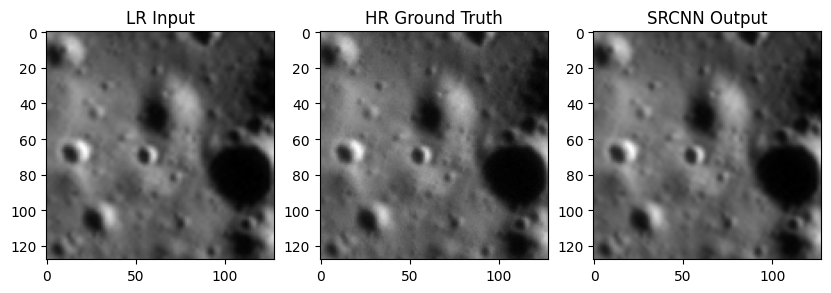

In [18]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    lr, hr = dataset[100]  # pick patch
    lr_in = lr.unsqueeze(0).to(device)
    pred = model(lr_in).cpu().squeeze().numpy()

plt.figure(figsize=(10,3))
plt.subplot(1,3,1); plt.imshow(lr.squeeze(), cmap='gray'); plt.title("LR Input")
plt.subplot(1,3,2); plt.imshow(hr.squeeze(), cmap='gray'); plt.title("HR Ground Truth")
plt.subplot(1,3,3); plt.imshow(pred, cmap='gray'); plt.title("SRCNN Output")
plt.show()


In [19]:
with torch.no_grad():
    lr, hr = dataset[100]  # patch
    lr_in = lr.unsqueeze(0).to(device)
    sr = model(lr_in).cpu().squeeze().numpy()  # super-resolved patch


In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_hazard_map(sr_patch, threshold=0.2):
    # Normalize to [0,255]
    img = (sr_patch * 255).astype(np.uint8)

    # Edge detection (hazards = strong edges)
    edges = cv2.Canny(img, 50, 150)

    # Dilate edges to highlight hazard zones
    kernel = np.ones((5,5), np.uint8)
    hazards = cv2.dilate(edges, kernel, iterations=1)

    # Create color map
    hazard_map = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Draw red circles around hazard areas
    contours, _ = cv2.findContours(hazards, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        (x,y), radius = cv2.minEnclosingCircle(cnt)
        if radius > 5:  # ignore small noise
            center = (int(x), int(y))
            radius = int(radius)
            cv2.circle(hazard_map, center, radius, (255,0,0), 2)  # red circle

    return hazard_map, len(contours) > 0  # return image + hazard flag


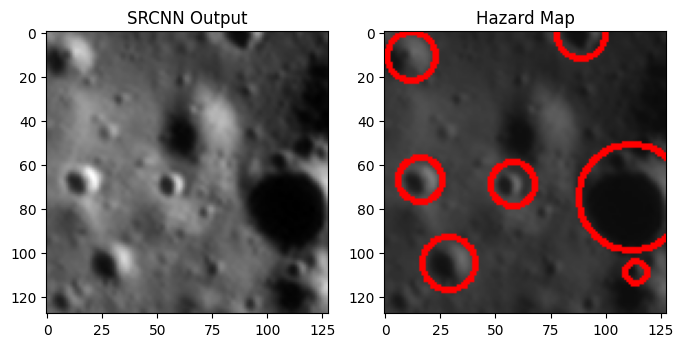

⚠️ Landing site: UNSAFE


In [21]:
hazard_map, unsafe = generate_hazard_map(sr)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(sr, cmap='gray'); plt.title("SRCNN Output")
plt.subplot(1,2,2); plt.imshow(hazard_map); plt.title("Hazard Map")
plt.show()

if unsafe:
    print("⚠️ Landing site: UNSAFE")
else:
    print("✅ Landing site: SAFE")


In [22]:
import numpy as np
import tifffile
import cv2
import torch
import matplotlib.pyplot as plt

def process_full_tiff(tiff_path, model, patch_size=128, stride=128, threshold=0.2):
    img = tifffile.memmap(tiff_path)
    H, W = img.shape

    # Final hazard map canvas (RGB)
    hazard_map = np.stack([img.astype(np.uint8)]*3, axis=-1)

    # Unsafe flag
    total_hazards = 0

    model.eval()
    with torch.no_grad():
        for y in range(0, H - patch_size, stride):
            for x in range(0, W - patch_size, stride):
                patch = img[y:y+patch_size, x:x+patch_size].astype(np.float32)

                # Normalize + tensor
                lr = torch.tensor(patch/255., dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

                # Super-resolve
                sr = model(lr).cpu().squeeze().numpy()

                # Detect hazards in this patch
                hazard_patch, has_hazard = generate_hazard_map(sr, threshold=threshold)

                if has_hazard:
                    total_hazards += 1
                    # Paste hazard circles back into global map
                    hazard_map[y:y+patch_size, x:x+patch_size] = cv2.addWeighted(
                        hazard_map[y:y+patch_size, x:x+patch_size], 0.7,
                        hazard_patch, 0.3, 0
                    )

    return hazard_map, total_hazards


In [24]:
def generate_hazard_map(sr_patch, threshold=0.2):
    """
    Takes a super-resolved patch and detects hazards.
    Returns: (RGB image with hazards marked, hazard_flag)
    """
    patch = (sr_patch * 255).astype(np.uint8)
    h, w = patch.shape
    rgb_patch = cv2.cvtColor(patch, cv2.COLOR_GRAY2BGR)

    # Normalize
    norm_patch = cv2.equalizeHist(patch)

    # Threshold (you can tune this for crater/rock detection)
    _, binary = cv2.threshold(norm_patch, int(threshold*255), 255, cv2.THRESH_BINARY)

    # Find contours (hazard candidates)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    hazard_flag = False
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 30:   # ignore tiny noise
            hazard_flag = True
            (x,y,wc,hc) = cv2.boundingRect(cnt)
            cv2.rectangle(rgb_patch, (x,y), (x+wc,y+hc), (0,0,255), 2)  # red box
            cv2.circle(rgb_patch, (x+wc//2,y+hc//2), 8, (0,255,0), 2)   # green circle center

    return rgb_patch, hazard_flag


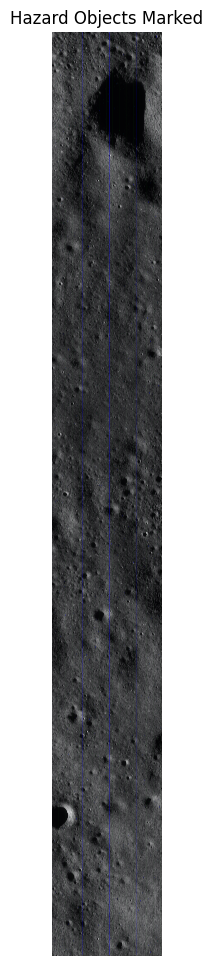

Total Hazards Detected: 73377
⚠️ Landing site: UNSAFE


In [26]:
hazard_map, total_hazards = process_full_tiff(
    tiff_path, model, patch_size=128, stride=128, threshold=0.2
)

out_path = "/content/Moon Datasets IMG/hazard_objects_full_1.png"
cv2.imwrite(out_path, cv2.cvtColor(hazard_map, cv2.COLOR_RGB2BGR))

plt.figure(figsize=(12,12))
plt.imshow(hazard_map)
plt.title("Hazard Objects Marked")
plt.axis("off")
plt.show()

print(f"Total Hazards Detected: {total_hazards}")
if total_hazards > 50:
    print("⚠️ Landing site: UNSAFE")
else:
    print("✅ Landing site: SAFE")
